# Earthquake Viewer

This notebook is for exploring the earthquake record in the vicinity of a chosen location.

**Enter location information:**  <a href='#location'>here</a>
 - Option 1. Use an address or location name (Google maps API key necessary)
 - Option 2. Enter latitude-longitude coordinates

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
import requests
import plotly.express as px

#### Define location mapping function

In [2]:
def address_to_coordinates(address):
    url = f'https://maps.googleapis.com/maps/api/directions/json?origin=Los+Angelesd&destination={address}&key={key}'
    res = requests.get(url)
    if res.status_code == 200:
        data_dict = res.json()
        
        try:
            lat = data_dict['routes'][0]['legs'][0]['end_location']['lat']
            lon = data_dict['routes'][0]['legs'][0]['end_location']['lng']
            return lat, lon
        except:
            try: 
                lat = data_dict['routes'][0]['legs']['end_location']['lat']
                lon = data_dict['routes'][0]['legs']['end_location']['lng']
                return lat, lon
            except:
                try: 
                    lat = data_dict['routes']['legs'][0]['end_location']['lat']
                    lon = data_dict['routes']['legs'][0]['end_location']['lng'] 
                    return lat, lon
                except:
                    try: 
                        lat = data_dict['routes']['legs']['end_location']['lat']
                        lon = data_dict['routes']['legs']['end_location']['lng'] 
                        return lat, lon
                    except:
                        return 0, 0
    else:
        return 0, 0

#### Prompt user for location

<a id='location'></a>

In [3]:
## OPTION 1: use a location or address (Google Maps key necessary)

# Enter Google Maps key
key = ''

#Enter address
address = 'Alhambra, CA'

# Call function to convert address to coordinates
[lat,lon] = address_to_coordinates(address)


# OPTION 2: enter latitude, longitude, and name of a location
if lat == 0 and lon == 0:
    
    # EDIT HERE
    lat = 34.1161191
    lon = -118.1503947
    address = 'South Pasadena (Default)'

# Convert to geopandas dataframe
userloc = pd.DataFrame({'latitude':[lat],'longitude':[lon]})
userloc = geopandas.GeoDataFrame(
    userloc, geometry=geopandas.points_from_xy(userloc.longitude, userloc.latitude))
userloc.crs = {'init' :'epsg:4326'}
userloc = userloc.to_crs(epsg=3857)

/Users/Sam/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Read in USGS data

In [4]:
#load earthquake data from 1950-2020
locmag = pd.read_csv('./datasets/eq_data.csv')
datlen = locmag.shape[0]

locmag = geopandas.GeoDataFrame(
    locmag, geometry=geopandas.points_from_xy(locmag.longitude, locmag.latitude))
locmag.crs = {'init' :'epsg:4326'}

# convert time to pandas datetime
locmag['time'] = pd.to_datetime(locmag['time'])
locmag['magsize'] = ((locmag['mag']**4)/3)+5

# read in faults
faults = geopandas.read_file('datasets/ca_faults/ca_faults.shp')

/Users/Sam/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Feature engineering

In [5]:
locmag['age'] = [(locmag['time'][0]-t).total_seconds()/86400 for t in locmag['time']]
locmag['year'] = pd.DatetimeIndex(locmag['time']).year
locmag['month'] = pd.DatetimeIndex(locmag['time']).month

### Generate map showing location of interest in context of greater Los Angeles area earthquakes

In [6]:
locmag['year'] = pd.DatetimeIndex(locmag['time']).year
locmag['month'] = pd.DatetimeIndex(locmag['time']).month
locmag['age'] = [(locmag['time'][0]-t).total_seconds()/86400 for t in locmag['time']]

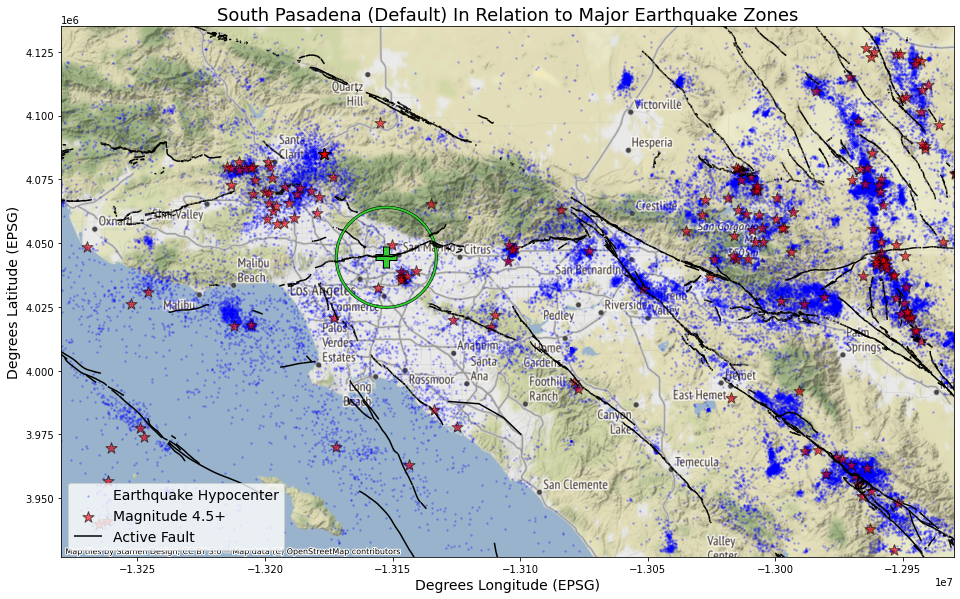

In [7]:
locmag = locmag.to_crs(epsg=3857)
base = locmag.plot(marker='.',markersize=10,color='b',figsize=(16,12),alpha=0.2,label='Earthquake Hypocenter')
locmag[locmag['mag'] >=4.5].plot(ax=base,marker='*',markersize=140,facecolor='r',edgecolor='k',alpha=0.6,label='Magnitude 4.5+')
plt.title(f'{address} In Relation to Major Earthquake Zones',fontsize=18)
plt.xlabel('Degrees Longitude (EPSG)',fontsize=14)
plt.ylabel('Degrees Latitude (EPSG)',fontsize=14)
ctx.add_basemap(base)
faults.plot(ax=base,color='k',label='Active Fault')
userloc.plot(ax=base,marker='+',markersize=500,facecolor='k',edgecolor='k',linewidth=7)
userloc.plot(ax=base,marker='+',markersize=380,facecolor='limegreen',edgecolor='k',linewidth=5)
userloc.plot(ax=base,marker='o',markersize=10000,facecolor='None',edgecolor='k',linewidth=3)
userloc.plot(ax=base,marker='o',markersize=10000,facecolor='None',edgecolor='limegreen',linewidth=2)
plt.xlim(-1.328e7,-1.293e7)
plt.ylim(3.927e6,4.135e6)
plt.legend(loc='lower left',fontsize=14);
#plt.savefig('./plots/la_quakes.png',dpi=235,bbox_inches='tight');

### Generate map of focus region

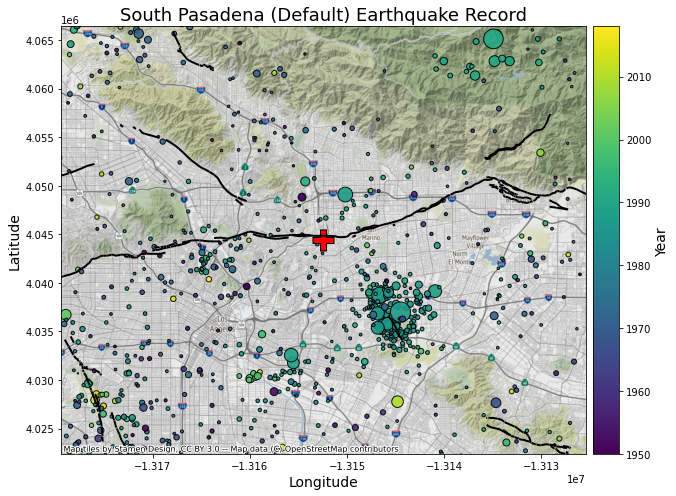

In [8]:
focus = locmag[(locmag['latitude'] <= lat+0.18) & 
       (locmag['latitude'] >= lat-0.18) & 
       (locmag['longitude'] <= lon+0.24) & 
       (locmag['longitude'] >= lon-0.24)]

fig, base = plt.subplots(1, 1,figsize=(10,10))
divider = make_axes_locatable(base)
cax = divider.append_axes("right", size="5%", pad=0.1)

faults.plot(ax=base,color='k',linewidth=2,label="Faults")
focus.plot(ax=base,figsize=(10,10),column='year',marker='o',markersize='magsize',cmap='viridis',cax=cax,edgecolor='k',alpha=0.9,legend=True)
userloc.plot(ax=base,marker='+',markersize=500,facecolor='k',edgecolor='k',linewidth=7)
userloc.plot(ax=base,marker='+',markersize=380,facecolor='r',edgecolor='k',linewidth=5)
base.set_title(f'{address} Earthquake Record',fontsize=18)
base.set_xlabel('Longitude',fontsize=14)
base.set_ylabel('Latitude',fontsize=14)
plt.ylabel('Year',fontsize=14)

# set figure bounds
x,y = userloc['geometry'][0].coords.xy
base.set_xlim(x[0]-27_000,x[0]+27_000)
base.set_ylim(y[0]-22_000,y[0]+22_000)

ctx.add_basemap(base)
#plt.savefig('./plots/alhambra_quakes.png',dpi=235,bbox_inches='tight');

### Local Earthquake Swarms

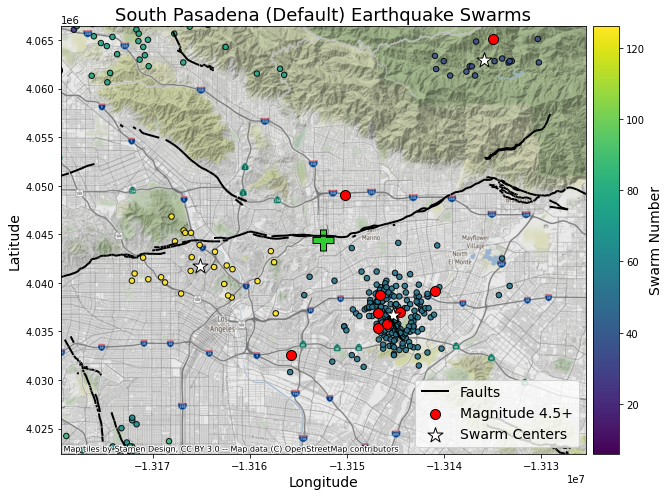

In [9]:
swarm = geopandas.read_file('datasets/eq_swarm.shp')
centers = geopandas.read_file('datasets/eq_swarm_centers.shp')

swarm = swarm.to_crs(epsg=3857)
centers = centers.to_crs(epsg=3857)

focus = swarm[(swarm['latitude'] <= lat+0.18) & 
       (swarm['latitude'] >= lat-0.18) & 
       (swarm['longitude'] <= lon+0.24) & 
       (swarm['longitude'] >= lon-0.24)]

fig, base = plt.subplots(1, 1,figsize=(10,10))
divider = make_axes_locatable(base)
cax = divider.append_axes("right", size="5%", pad=0.1)

faults.plot(ax=base,color='k',linewidth=2,label="Faults")
focus.plot(ax=base,figsize=(10,10),column='label',marker='o',markersize=30,cmap='viridis',cax=cax,edgecolor='k',alpha=0.9,legend=True)
locmag[locmag['mag'] >=4.5].plot(ax=base,marker='o',markersize=100,facecolor='r',edgecolor='k',label='Magnitude 4.5+')
userloc.plot(ax=base,marker='+',markersize=500,facecolor='k',edgecolor='k',linewidth=7)
userloc.plot(ax=base,marker='+',markersize=380,facecolor='limegreen',edgecolor='k',linewidth=5)
centers.plot(ax=base,marker='*',markersize=250,facecolor='w',edgecolor='k',label='Swarm Centers')

base.set_title(f'{address} Earthquake Swarms',fontsize=18)
base.set_xlabel('Longitude',fontsize=14)
base.set_ylabel('Latitude',fontsize=14)
plt.ylabel('Swarm Number',fontsize=14)
base.legend(fontsize=14)

# set figure bounds
x,y = userloc['geometry'][0].coords.xy
base.set_xlim(x[0]-27_000,x[0]+27_000)
base.set_ylim(y[0]-22_000,y[0]+22_000)

ctx.add_basemap(base)
#plt.savefig('./plots/alhambra_swarm.png',dpi=235,bbox_inches='tight');

### Generate 3D interactive map of earthquakes in focus region

In [10]:
focus['depth'] = -1*focus['depth']
focus['magsize'] = ((focus['mag']**4)/3)+5

px.scatter_3d(focus, x='longitude', y='latitude', z='depth',size='magsize',color='age')

<ipython-input-10-da1e7ade3dcc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus['depth'] = -1*focus['depth']
<ipython-input-10-da1e7ade3dcc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus['magsize'] = ((focus['mag']**4)/3)+5
